# Praca domowa 5
#### Mateusz Grzyb

## Wczytanie bibliotek

In [519]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import AffinityPropagation

## Wczytanie danych

In [356]:
data=pd.read_csv('../../clustering.csv', header=None)
data.columns=['X', 'Y']
data

,X,Y
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186
...,...,...
395,22.423142,50.252807
396,-58.534367,-78.679387
397,36.446549,-11.841887
398,-101.284845,85.096034


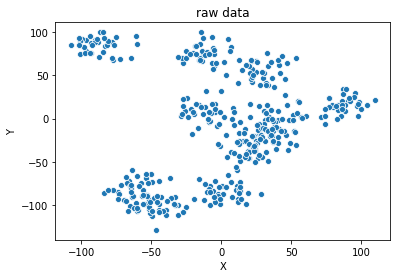

In [357]:
sns.scatterplot(data=data, x='X', y='Y')
plt.title('raw data')
plt.show()

Gdybym miał zgadywać, to powiedziałbym, że zbiór ten jest wynikiem funkcji make_blobs z parametrem centers=10.

Powiedziałbym również, że "na oko" widać 8-10 klastrów, ponieważ niektóre z nich leżą szczególnie blisko siebie i mogłyby być traktowane jako jeden klaster.

Z drugiej strony, patrzenie na 3-4 większe skupienia również nie wydaje się być pozbawione sensu.

## Klasteryzacja

### KMeans + Elbow/Silhouette method

Najpierw, zdefiniujmy kilka funkcji.

In [358]:
def kmeans_plot(data, n_clusters):
    kmeans=KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data)
    
    prediction=kmeans.predict(data)
    sns.scatterplot(data=data, x='X', y='Y', hue=prediction, s=30, palette='viridis', legend=False)
    
    centers=kmeans.cluster_centers_
    sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='black', s=150, alpha=0.5)
    
    plt.title('k-means clusters\nn_clusters=%s'%(n_clusters))
    
def kmeans_wcss(data, cluster_num):
    WCSSs=[]
    
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
    
    for k in cluster_num_iter:
        kmeans=KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        WCSS=kmeans.score(data)*(-1)
        WCSSs.append(WCSS)
    
    if isinstance(cluster_num, int):
        return WCSSs[0]
    else:
        return WCSSs

def kmeans_silhouette(data, cluster_num):
    silhouettes=[]
    
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    for k in cluster_num_iter:
        kmeans=KMeans(n_clusters=k, random_state=0)
        prediction=kmeans.fit_predict(data)
        silhouette=silhouette_score(data, prediction)
        silhouettes.append(silhouette)
        
    if isinstance(cluster_num, int):
        return silhouettes[0]
    else:
        return silhouettes

#### Elbow Method

Spróbujmy określić optymalną liczbę klastrów za pomocą 'Elbow Method'.

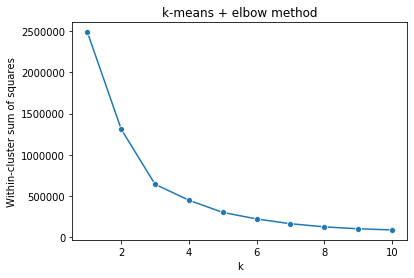

In [359]:
WCSSs=kmeans_wcss(data, range(1, 11))
x=range(1, 11)
sns.lineplot(x=x, y=WCSSs, marker='o')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('k-means + elbow method')
plt.show()

Przełamanie wykresu jest najbardziej zauważalne dla k=3. Dokonajmy takiej klasteryzacji.

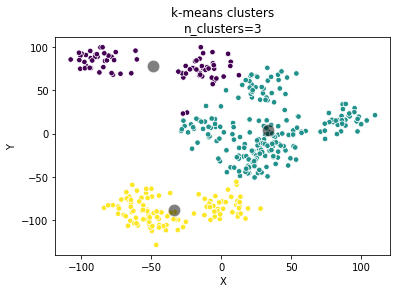

In [360]:
kmeans_plot(data, 3)

Tak jak wspominałem wcześniej, taka liczba klastrów nie wydaje się być pozbawiona sensu. Możnaby powiedzieć, że przy doborze etykiet głównie ma tu znaczenie współrzędna Y.

Sama metoda łokciowa jest prosta w użyciu. Niestety, posiada ona poważne wady: sprawia wrażenie mało precyzyjnej oraz typuje tylko jedną liczbę klastrów jako optymalną, gdzie w rzeczywistości może istnieć kilka rozwiązań tego problemu.

#### Silhouette method

Teraz, spróbujmy określić optymalną liczbę klastrów za pomocą 'Silhouette Method'.

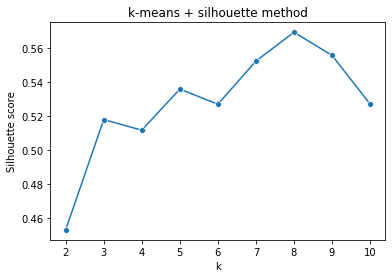

In [361]:
silhouettes=kmeans_silhouette(data, range(2, 11))
x=range(2, 11)
sns.lineplot(x=x, y=silhouettes, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('k-means + silhouette method')
plt.show()

Najwyższy wynik mamy dla k=8. Dokonajmy takiej klasteryzacji.

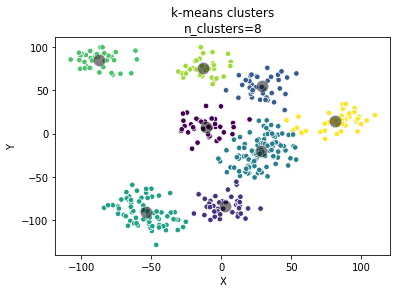

In [439]:
kmeans_plot(data, 8)

Moim zdaniem podział ten wygląda bardzo dobrze. Algorytm połączył ze sobą "bloby", które rzeczywiście wizualnie oceniłbym na najbardziej zbliżone.

Metoda silhouette informuje nas nie tylko o liczbie klastrów, dla której wynik był największy, ale także o alternatywach, które zauważalnie się wyróżniały (k=5). Dokonajmy takiej klasteryzacji.

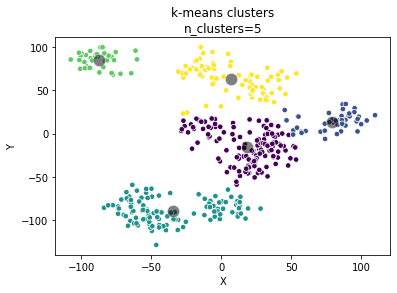

In [440]:
kmeans_plot(data, 5)

Ten podział również nie wygląda irracjonalnie, ale osobiście nie wybrałbym takiej liczby klastrów.

### KMedoids + Silhouette method

Najpierw, zdefiniujmy kilka funkcji.

In [364]:
def kmedoids_plot(data, n_clusters):
    kmedoids=KMedoids(n_clusters=n_clusters, random_state=0)
    kmedoids.fit(data)
    
    prediction=kmedoids.predict(data)
    sns.scatterplot(data=data, x='X', y='Y', hue=prediction, s=30, palette='viridis', legend=False)
    
    centers=kmedoids.cluster_centers_
    sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='black', s=150, alpha=0.5)
    
    plt.title('k-medoids clusters\nn_clusters=%s'%(n_clusters))
    
def kmedoids_silhouette(data, cluster_num):
    silhouettes=[]
    
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    for k in cluster_num_iter:
        kmedoids=KMedoids(n_clusters=k, random_state=0)
        prediction=kmedoids.fit_predict(data)
        silhouette=silhouette_score(data, prediction)
        silhouettes.append(silhouette)
        
    if isinstance(cluster_num, int):
        return silhouettes[0]
    else:
        return silhouettes
    
def compare(data, n_clusters):
    fig=plt.figure(figsize=(13.5, 4))
    
    plt.subplot(1, 2, 1)
    kmeans_plot(data, n_clusters)
    
    plt.subplot(1, 2, 2)
    kmedoids_plot(data, n_clusters)

#### Silhouette method

Spróbujmy określić optymalną liczbę klastrów za pomocą 'Silhouette Method'.

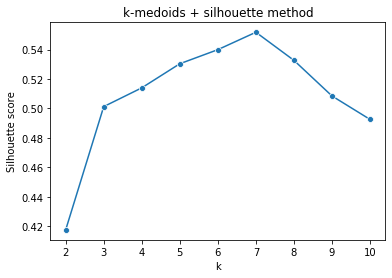

In [365]:
silhouettes=kmedoids_silhouette(data, range(2, 11))
x=list(range(2, len(silhouettes) + 2))
sns.lineplot(x=x, y=silhouettes, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('k-medoids + silhouette method')
plt.show()

Ty razem widoczny jest tylko jeden peak, dla liczby klastrów k=7. Dokonajmy takiej klasteryzacji.

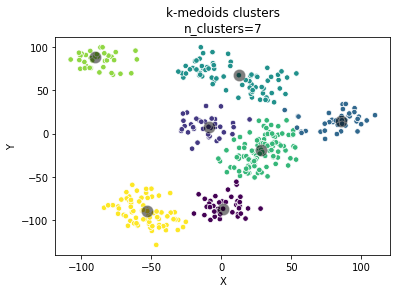

In [366]:
kmedoids_plot(data, 7)

Podział ten nie wygląda źle, ale subiektywnie preferuję podział na 8 klastrów, ponieważ w górnej, ciemnozielonej grupie granica jest dosyć dobrze widoczna.

#### K-Means vs. K-Medoids


Porównajmy jeszcze różnice między podziałami, dokonananymi za pomocą dwóch, przedstawionych dotychczas metod, dla innych liczb klastrów.

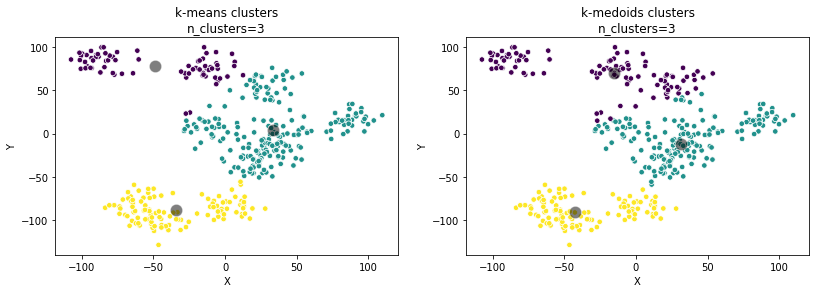

In [444]:
compare(data, 3)

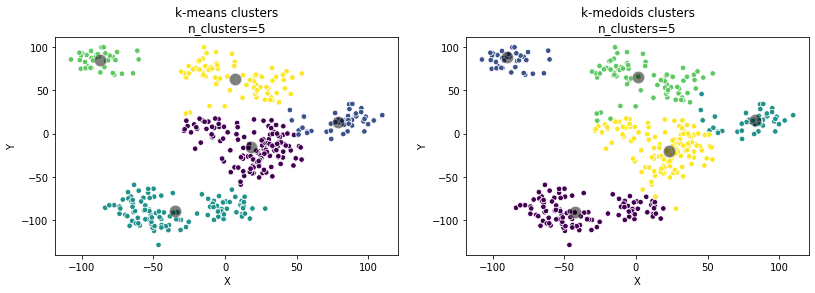

In [369]:
compare(data, 5)

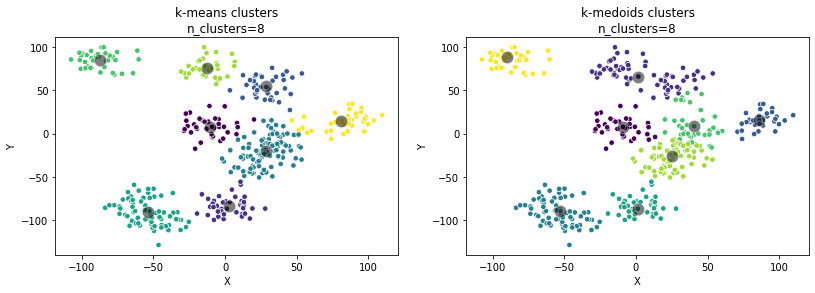

In [443]:
compare(data, 8)

Różnice dla k=3 i k=5 są raczej subtelne. Natomiast dla k=8 subiektywnie oceniłbym wynik działania algorytmu K-Means za lepszy.

### Agglomerative Clustering i Dendrogram

Najpierw, zdefiniujmy kilka funkcji.

In [370]:
def agglomerative_clustering_plot(data, linkage, distance_threshold):
    ac=AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, linkage=linkage)
    
    prediction=ac.fit_predict(data)
    sns.scatterplot(data=data, x='X', y='Y', hue=prediction, s=30, palette='viridis', legend=False)
    plt.title('agglomerative clustering clusters\nlinkage=%s\ndistance_threshold=%s'%(linkage, distance_threshold))

def plot_dendrogram(model, **kwargs):
    counts=np.zeros(model.children_.shape[0])
    n_samples=len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count=0
        for child_idx in merge:
            if child_idx<n_samples:
                current_count+=1
            else:
                current_count+=counts[child_idx-n_samples]
        counts[i]=current_count

    linkage_matrix=np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Spójrzmy teraz na dendrogramy przygotowane dla różnych wartości parametru linkage.

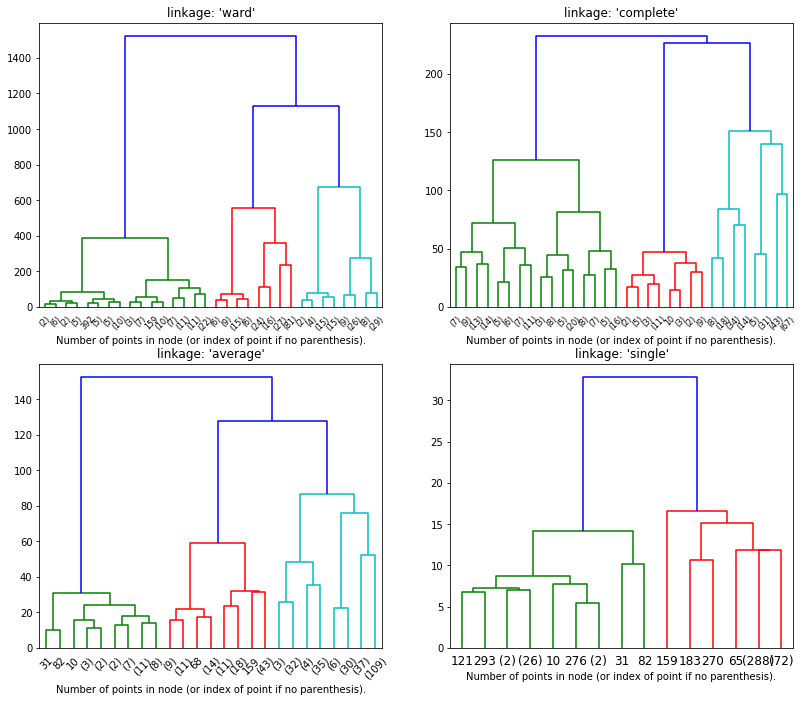

In [371]:
linkages=['ward', 'complete', 'average', 'single']

fig=plt.figure(figsize=(13.5, 11.5))
for i in range(0, len(linkages)):
    plt.subplot(2, 2, i+1)
    ac=AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkages[i])
    ac=ac.fit(data)
    plot_dendrogram(ac, truncate_mode='level', p=4)
    plt.title('linkage: \'%s\''%linkages[i])
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")

Dokonajmy teraz klasteryzacji dla wszystkich wartości parametru linkage i różnych wartości parametru distance_threshold, wybranych na podstawie powyższych dendrogramów. Postaram się uzyskać podziały na 3, 4, 5 i 8 grup.

In [433]:
def plot_linkage_threshold(linkage, distance_thresholds):
    fig=plt.figure(figsize=(18, 5*(len(distance_thresholds)//4+(0 if len(distance_thresholds)%4==0 else 1))))
    for i in range(0, len(distance_thresholds)):
        plt.subplot((len(distance_thresholds)//4+(0 if len(distance_thresholds)%4==0 else 1)), 4, i+1)
        agglomerative_clustering_plot(data, linkage=linkage, distance_threshold=distance_thresholds[i])
    fig.tight_layout(pad=2)

#### Ward

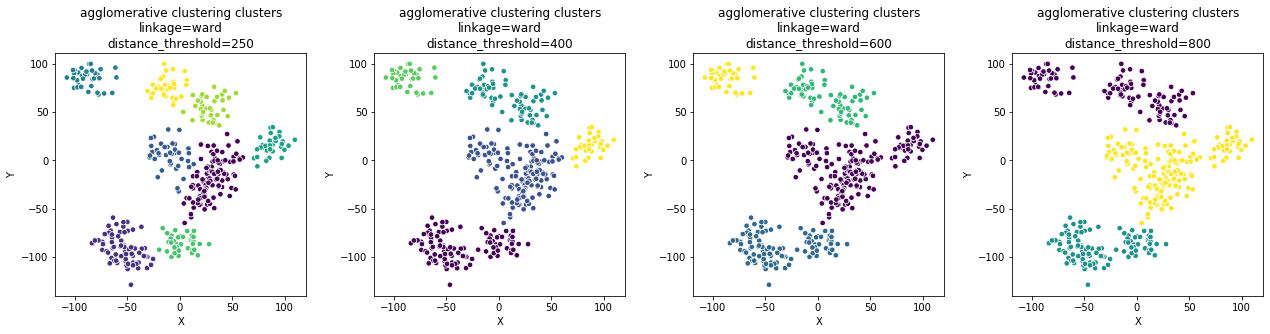

In [484]:
plot_linkage_threshold('ward', [250, 400, 600, 800])

#### Complete

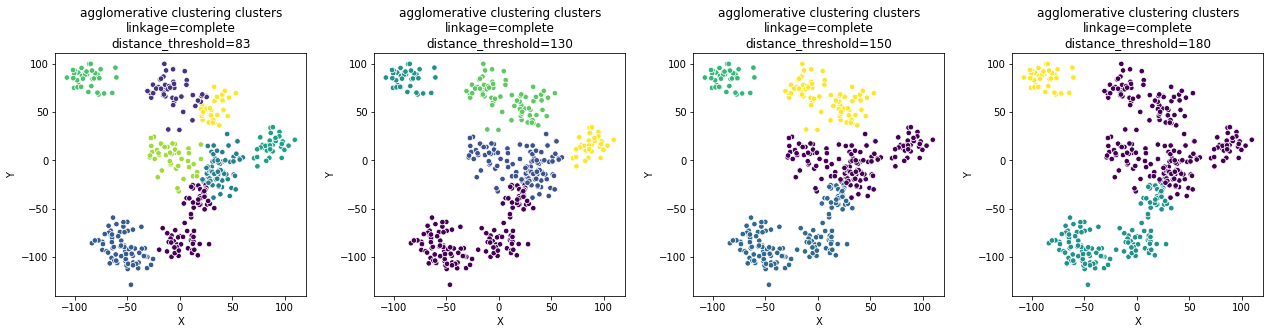

In [485]:
plot_linkage_threshold('complete', [83, 130, 150, 180])

#### Average

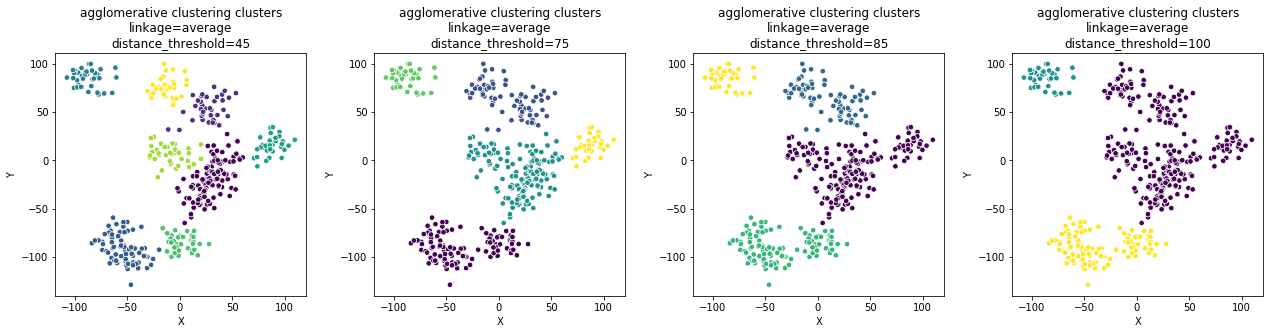

In [486]:
plot_linkage_threshold('average', [45, 75, 85, 100])

#### Single

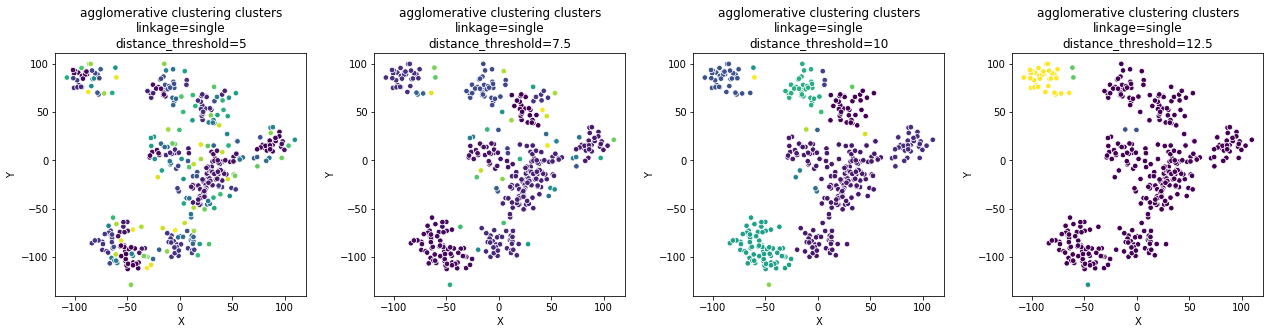

In [488]:
plot_linkage_threshold('single', [5, 7.5, 10, 12.5])

Wszystkie trzy metody Ward, Complete i Average pozwoliły na uzyskanie sensownych wyników, natomiast metoda Single nie sprawdziła się w przypadku rozważanego zbioru (co nie znaczy, że nie może być użyteczna w innych sytuacji).

Widoczne są pewne różnice między metodami, dla poszczególnych liczb klastrów i tak za najlepsze podziały uznałbym te, dokonane przy pomocy metod Ward i Average, jednocześnie odrzucając dla tego zbioru metody Complete i Single.

### Krótkie testy innych metod

#### Mean-shift

Bandwidth (a co za tym idzie - liczbę klastrów) możemy estymować gotową funkcją.

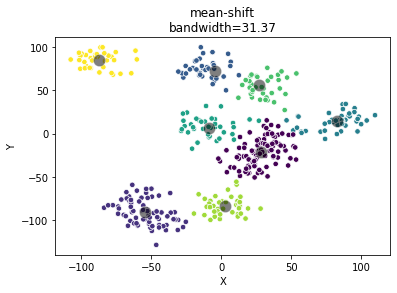

In [517]:
# parametry dobrałem w wyniku kilku ręcznych prób, chcąc uzyskać 8 klastrów
bandwidth = estimate_bandwidth(data, quantile=0.1)
ms=MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)
prediction=ms.predict(data)
sns.scatterplot(data=data, x='X', y='Y', hue=prediction, s=30, palette='viridis', legend=False)
centers=ms.cluster_centers_
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='black', s=150, alpha=0.5)
plt.title('mean-shift\nbandwidth=%.2f'%(bandwidth))
plt.show()

Podział wygląda dobrze, nie różni się znacznie od innych podziałów na 8 klastrów.

#### Affinity Propagation

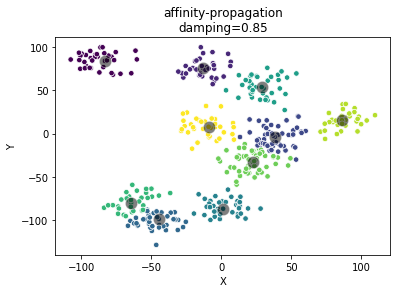

In [539]:
damping=0.85
af=AffinityPropagation(damping=damping)
af.fit(data)
prediction=af.predict(data)
sns.scatterplot(data=data, x='X', y='Y', hue=prediction, s=30, palette='viridis', legend=False)
centers=af.cluster_centers_
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='black', s=150, alpha=0.5)
plt.title('affinity-propagation\ndamping=%.2f'%(damping))
plt.show()

Po dostosowaniu paramatru damping algorytm poprawnie wykrył wszystkie 10 podejrzewanych przeze mnie "blobów".